In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parents[0]  # importing functions from other folders
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from _data.data_utils import read_in
from _fitting.fitting_utils import hist_plot, CI_plot, CI_plot_alt, CI_plot_both, plot_posteriors_side_by_side, plot_spline
from _fitting.model_utils import build_model, data_settings_to_name, model_settings_to_name, abbrev_stat, settings_to_var_names, elpd_to_xr, elpd_to_row, model_fit, create_html_report
import pymc as pm
import arviz as az
from patsy import dmatrix
import nutpie
import time
from pprint import pprint
from IPython.display import display
import seaborn as sns
from pymc.variational.callbacks import CheckParametersConvergence
import xarray as xr
import pickle
import warnings

az.style.use("arviz-darkgrid")


if '___laptop' in os.listdir('../'):
    # laptop folder
    folder = "../../_data/p-dengue/"
elif '___server' in os.listdir('../'):
    # server folder
    folder = "../../../../../data/lucaratzinger_data/p_dengue/"

In [2]:
data_settings = {'admin':2, 'max_lag':6, 'start_year':2016, 'start_month':1, 'end_year':2019, 'end_month':12}
data_name = data_settings_to_name(data_settings)
data = read_in(folder, **data_settings, standardise=True, dropna=True, celsius=True, tp_log=True)
print('data: ',data_name)

data:  a2_201601_201912


In [3]:
if '___laptop' in os.listdir('../'):
    # laptop folder
    outpath = "../../_data/p-dengue/model_fits/"
elif '___server' in os.listdir('../'):
    # server folder
    outpath = "../../../../../data/lucaratzinger_data/p_dengue/model_fits"

In [ ]:
model_dict = {}
for surv in [None, 'surveillance_pop_weighted', 'urban_surveillance_pop_weighted'][0:2]:
    settings = {
            'surveillance_name':surv,
            'urbanisation_name':None,
            'stat_names':['tp_24hmean_pop_weighted_log(0)'], 'degree':3, 'num_knots':5, 'knot_type':'quantile','orthogonal':True}
    model_dict[model_settings_to_name(settings)] = settings

for model_name, model_settings in model_dict.items():
    print('model: ', model_name)
    model_fit(data, data_name, model_settings, outpath, n_chains=2, n_draws=20, n_tune=50, invert_log=True)
    break


Only 20 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


model:  [nosurv__nourb][tp_24hmean_log_p(0)][3,5,q,o]


---

In [ ]:
# Load pointwise values from two models
data_a = np.load(os.path.join(os.path.join(outpath, 'a2_201601_201912/metrics/'), os.listdir(os.path.join(outpath, 'a2_201601_201912/metrics/'))[0]))
data_b = np.load(os.path.join(os.path.join(outpath, 'a2_201601_201912/metrics/'), os.listdir(os.path.join(outpath, 'a2_201601_201912/metrics/'))[1]))

# Compare using LOO
loo_diff = data_a['loo_pointwise'].sum() - data_b['loo_pointwise'].sum()
loo_diff_se = np.std(data_a['loo_pointwise'] - data_b['loo_pointwise']) * np.sqrt(len(data_a['loo_pointwise']))

print(f"ELPD difference: {loo_diff:.2f} ± {loo_diff_se:.2f}")
print(f"Model A is better" if loo_diff > 0 else "Model B is better")

# Or use WAIC
waic_diff = data_a['waic_pointwise'].sum() - data_b['waic_pointwise'].sum()
waic_diff_se = np.std(data_a['waic_pointwise'] - data_b['waic_pointwise']) * np.sqrt(len(data_a['waic_pointwise']))

ELPD difference: -579.85 ± 123.84
Model B is better


In [ ]:
def compare_models(outpath, data_name, task, metric="loo"):
    """
    Compare multiple models using pointwise ELPD values.
    Mimics ArviZ's compare() output format.
    
    Args:
        outpath: base path to model fits
        data_name: name of the data folder (e.g., 'a2_201601_201912')
        task: subfolder name (e.g., 'variable_selection')
        metric: 'loo' or 'waic'
    
    Returns:
        DataFrame with model comparison results ranked by ELPD
    """
    
    # Find all npz files
    metrics_path = os.path.join(outpath, f'{data_name}[{task}]/metrics')
    npz_files = [os.path.join(metrics_path, f) for f in os.listdir(metrics_path)]
    
    if len(npz_files) == 0:
        raise ValueError(f"No files found in {metrics_path}")
    
    print(f"Comparing models using {metric.upper()}")
    print("="*100)
    
    # Load all models
    models = {}
    for npz_file in npz_files:
        model_name = os.path.basename(npz_file)[9:-5]  # Extract from _metrics[...].npz
        data = np.load(npz_file)
        models[model_name] = data[f'{metric}_pointwise']
    
    # Build comparison dataframe
    results = []
    for name, pointwise in models.items():
        results.append({
            'model': name,
            f'{metric}': pointwise.sum(),
            f'p_{metric}': len(pointwise),  # effective number of parameters
            f'{metric}_se': np.std(pointwise) * np.sqrt(len(pointwise)),
        })
    
    df = pd.DataFrame(results)
    
    # Sort by ELPD (higher is better for elpd_loo, lower is better for looic)
    # ArviZ reports as negative (looic), but we keep as positive (elpd)
    df = df.sort_values(f'{metric}', ascending=False).reset_index(drop=True)
    
    # Add rank
    df.insert(0, 'rank', range(len(df)))
    
    # Calculate differences from best model (rank 0)
    best_name = df.iloc[0]['model']
    best_pointwise = models[best_name]
    
    d_metric = []
    d_se = []
    weight = []
    
    for idx, row in df.iterrows():
        current_pointwise = models[row['model']]
        
        # Difference from best (best - current, so negative means worse)
        diff_pointwise = best_pointwise - current_pointwise
        diff = diff_pointwise.sum()
        diff_se = np.std(diff_pointwise) * np.sqrt(len(diff_pointwise))
        
        d_metric.append(diff)
        d_se.append(diff_se)
        
        # Akaike weight
        weight.append(np.exp(-0.5 * diff))
    
    # Normalize weights
    weight = np.array(weight)
    weight = weight / weight.sum()
    
    df[f'd{metric}'] = d_metric
    df['dse'] = d_se
    df['weight'] = weight
    
    # Set model as index (like ArviZ does)
    df = df.set_index('model')
    
    # Reorder columns to match ArviZ output
    column_order = ['rank', f'{metric}', f'p_{metric}', f'd{metric}', 'weight', f'{metric}_se', 'dse']
    df = df[column_order]
    df = df.round(2)
    
    print(df.to_string())
    print("="*100)
    
    return df

In [ ]:
data_name = "a2_201601_201912"
task='surv'
outpath = "../../../../../data/lucaratzinger_data/p_dengue/model_fits"

comparison_df = compare_models(outpath, data_name, task=task, metric="waic")


Comparing models using WAIC
                               rank        waic  p_waic      dwaic  weight  waic_se      dse
model                                                                                       
[surv_p__nourb][nostat][]         0 -2639362.42   24107       0.00     1.0  5947.04     0.00
[urb_surv_p__nourb][nostat][]     1 -2754668.99   24107  115306.57     0.0  5884.18  1120.83
[nosurv__nourb][nostat][]         2 -2928835.12   24107  289472.70     0.0  5618.21  2143.67


In [4]:
import arviz as az
import numpy as np
import xarray as xr
from arviz.stats.stats_utils import ELPDData


In [5]:
os.listdir('../../../../../data/lucaratzinger_data/p_dengue/model_fits/a2_201601_201912[surv]/idata')

['idata_[[surv_p__nourb][nostat][]].nc',
 'idata_[[urb_surv_p__nourb][nostat][]].nc',
 'idata_[[nosurv__nourb][nostat][]].nc']

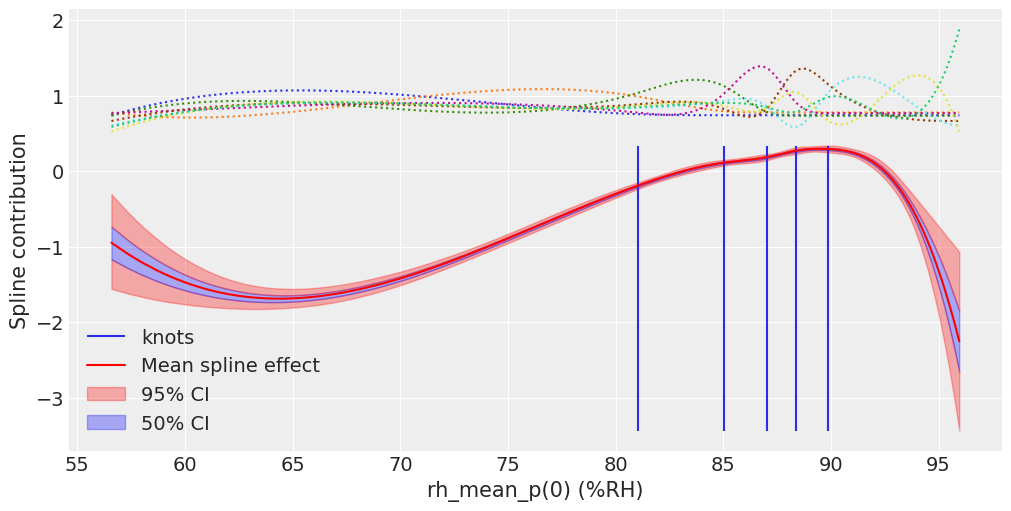

In [6]:
idata = az.from_netcdf('../../../../../data/lucaratzinger_data/p_dengue/model_fits/a2_201601_201912[surv+urb_p+s1]0/idata/idata_[[nosurv__urb_p][rh_mean_p(0)][3,5,q,o]].nc')

orthogonal = True
stat_name = 'rh_mean_pop_weighted(0)'
var = "w(rh_mean_pop_weighted(0))"
sigma_var = "sigma_w(rh_mean_pop_weighted(0))"
degree = 3
d = data[stat_name]
num_knots = 5
knot_list = np.percentile(d, np.linspace(0, 100, num_knots + 2))[1:-1]
B = dmatrix(f"bs(s, knots=knots, degree=degree, include_intercept=False)-1",
                        {"s": data[stat_name], "knots": knot_list, "degree":degree})
if orthogonal:
    B = np.asarray(B)
    B = (B - B.mean(axis=0)) / B.std(axis=0)
    B, _ = np.linalg.qr(B)

fig = plot_spline(idata, stat_name, var, sigma_var, B, d, knots=knot_list, figsize=(10,5), show_basis=True, basis_scale=4, orthogonal=True, invert_log=True);

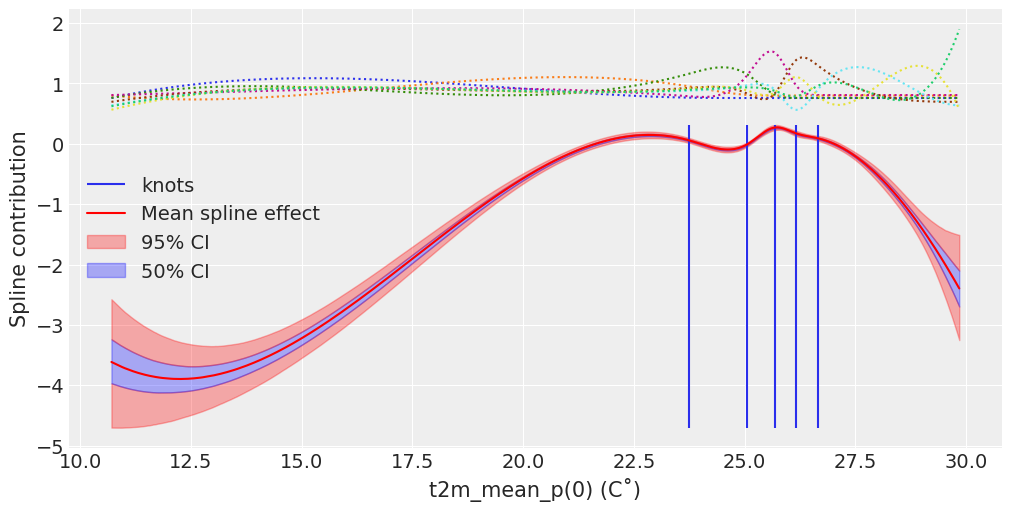

In [7]:
idata = az.from_netcdf('../../../../../data/lucaratzinger_data/p_dengue/model_fits/a2_201601_201912[surv+urb_p+s1]0/idata/idata_[[nosurv__urb_p][t2m_mean_p(0)][3,5,q,o]].nc')

orthogonal = True
stat_name = 't2m_mean_pop_weighted(0)'
var = "w(t2m_mean_pop_weighted(0))"
sigma_var = "sigma_w(t2m_mean_pop_weighted(0))"
degree = 3
d = data[stat_name]
num_knots = 5
knot_list = np.percentile(d, np.linspace(0, 100, num_knots + 2))[1:-1]
B = dmatrix(f"bs(s, knots=knots, degree=degree, include_intercept=False)-1",
                        {"s": data[stat_name], "knots": knot_list, "degree":degree})
if orthogonal:
    B = np.asarray(B)
    B = (B - B.mean(axis=0)) / B.std(axis=0)
    B, _ = np.linalg.qr(B)

fig = plot_spline(idata, stat_name, var, sigma_var, B, d, knots=knot_list, figsize=(10,5), show_basis=True, basis_scale=4, orthogonal=True, invert_log=True);

In [4]:
%matplotlib inline

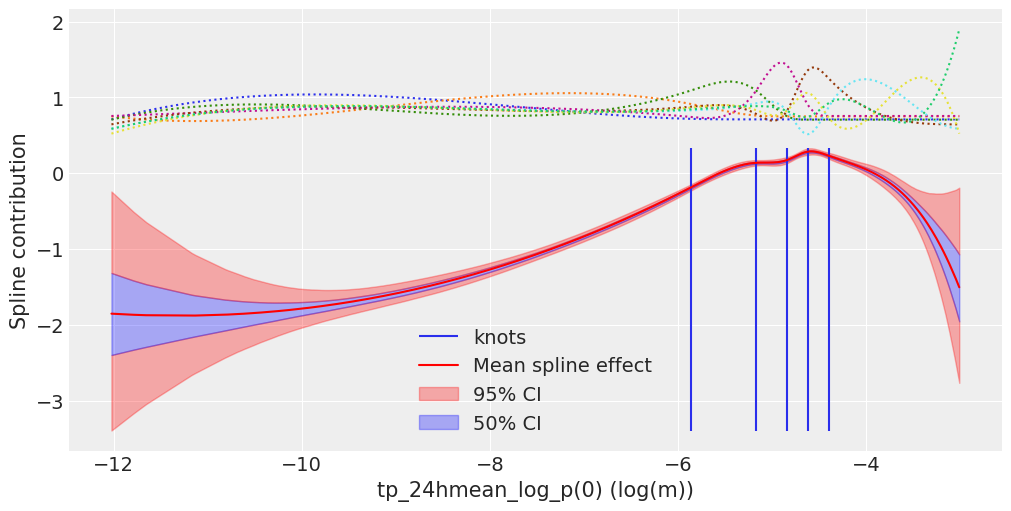

In [8]:
idata = az.from_netcdf('../../../../../data/lucaratzinger_data/p_dengue/model_fits/a2_201601_201912[surv+urb_p+s1]0/idata/idata_[[nosurv__urb_p][tp_24hmean_log_p(0)][3,5,q,o]].nc')

orthogonal = True
stat_name = 'tp_24hmean_pop_weighted_log(0)'
var = "w(tp_24hmean_pop_weighted_log(0))"
sigma_var = "sigma_w(tp_24hmean_pop_weighted_log(0))"
degree = 3
d = data[stat_name]
num_knots = 5
knot_list = np.percentile(d, np.linspace(0, 100, num_knots + 2))[1:-1]
B = dmatrix(f"bs(s, knots=knots, degree=degree, include_intercept=False)-1",
                        {"s": data[stat_name], "knots": knot_list, "degree":degree})
if orthogonal:
    B = np.asarray(B)
    B = (B - B.mean(axis=0)) / B.std(axis=0)
    B, _ = np.linalg.qr(B)

fig = plot_spline(idata, stat_name, var, sigma_var, B, d, knots=knot_list, figsize=(10,5), show_basis=True, basis_scale=4, orthogonal=True, invert_log=False);